# Fast_Multi Booster

inspired by [Gradient Boosted Decision Trees for High Dimensional Sparse Output](http://www.stat.ucdavis.edu/%7Echohsieh/rf/icml_sparse_GBDT.pdf)

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
from sklearn.metrics import log_loss
import time
%matplotlib inline

Data from [Kaggle Otto competition](https://www.kaggle.com/c/otto-group-product-classification-challenge)

In [2]:
train = pd.read_csv('input/otto_train.csv')
print(train.shape)

(61878, 95)


In [3]:
def encode_features(dat):
    df = pd.DataFrame(index=dat.index.values)
    for c in dat.columns.values:
        unq = np.unique(dat[c])
        arr = np.zeros(len(df))
        for ii, u in enumerate(unq):
            flg = (dat[c] == u).values
            arr[flg] = ii
        df[c] = arr.astype(int)
    return df

In [4]:
x = encode_features(train.drop(['id', 'target'], axis=1))
y = np.array([int(v.split('_')[1])-1 for v in train.target])
print(x.shape, y.shape)

(61878, 93) (61878,)


In [5]:
num_cls = len(np.unique(y))
print(num_cls)

9


In [6]:
np.random.seed(20161218)
flg_train = np.random.choice([False, True], len(y), p=[0.3, 0.7])
flg_valid = np.logical_not(flg_train)

In [7]:
dt_lgb   = lgb.Dataset(x[flg_train], y[flg_train])
dv_lgb   = lgb.Dataset(x[flg_valid], y[flg_valid], reference=dt_lgb)

### GBDT booster

In [8]:
prm_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': num_cls,
    'num_leaves' : 2**5-1,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq' : 1,
    'metric': 'multi_logloss',
}
num_round = 100

In [9]:
time_s = time.time()
obj_gbdt = lgb.train(
    prm_lgb, dt_lgb, num_boost_round=num_round,
    #valid_sets=dv_lgb
)
time_t = time.time()
time_gbdt = time_t - time_s
loss_gbdt = [
    log_loss(y[flg_train], obj_gbdt.predict(x[flg_train])),
    log_loss(y[flg_valid], obj_gbdt.predict(x[flg_valid]))
]
print(time_gbdt)
print(loss_gbdt)

12.959201097488403
[0.39572366741363918, 0.52176887577053011]


### Fast_Multi booster

Parameters

* boosting_type: 'fast_multi'
* num_class_train: number of class training per iteration

In [10]:
prm_lgb.update({
    'boosting_type': 'fast_multi',
    'num_class_train': 1,
})

In [11]:
time_s = time.time()
obj_fm = lgb.train(
    prm_lgb, dt_lgb, num_boost_round=num_round,
    #valid_sets=dv_lgb
)
time_t = time.time()
time_fm = time_t - time_s
loss_fm = [
    log_loss(y[flg_train], obj_gbdt.predict(x[flg_train])),
    log_loss(y[flg_valid], obj_gbdt.predict(x[flg_valid]))
]
print(time_fm)
print(loss_fm)

1.8654110431671143
[0.39572366741363918, 0.52176887577053011]


In [12]:
res = []
for ii in range(num_cls):
    prm_lgb.update({'num_class_train': ii+1})
    time_s = time.time()
    obj_fm = lgb.train(
        prm_lgb, dt_lgb, num_boost_round=num_round,
        #valid_sets=dv_lgb
    )
    time_t = time.time()
    res.append((
        time_t - time_s,
        log_loss(y[flg_train], obj_fm.predict(x[flg_train])),
        log_loss(y[flg_valid], obj_fm.predict(x[flg_valid]))
    ))
df = pd.DataFrame(res)
df.columns = ['time', 'train', 'valid']
df.index   = df.index +1

In [13]:
df['time_gbdt']  = time_gbdt
df['train_gbdt'] = loss_gbdt[0]
df['valid_gbdt'] = loss_gbdt[1]

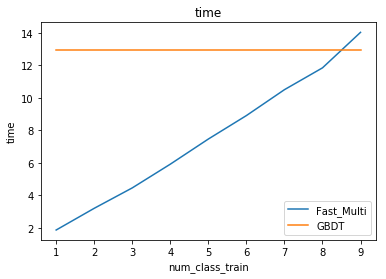

In [14]:
fig = plt.figure()
plt.plot(df.time, label='Fast_Multi')
plt.plot(df.time_gbdt, label='GBDT')
plt.legend()
plt.title('time')
plt.xlabel('num_class_train')
plt.ylabel('time')
plt.show()

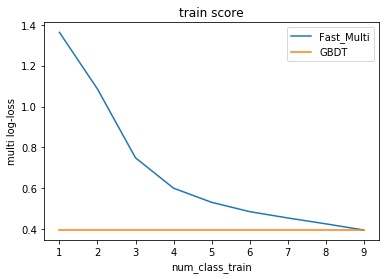

In [15]:
fig = plt.figure()
plt.plot(df.train, label='Fast_Multi')
plt.plot(df.train_gbdt, label='GBDT')
plt.legend()
plt.title('train score')
plt.xlabel('num_class_train')
plt.ylabel('multi log-loss')
plt.show()

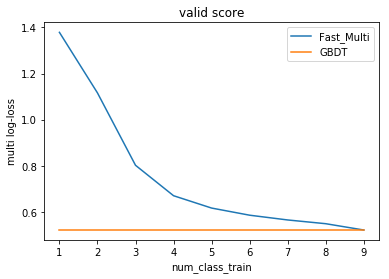

In [16]:
fig = plt.figure()
plt.plot(df.valid, label='Fast_Multi')
plt.plot(df.valid_gbdt, label='GBDT')
plt.legend()
plt.title('valid score')
plt.xlabel('num_class_train')
plt.ylabel('multi log-loss')
plt.show()